In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import pyroounfold
from pyroounfold.toy_unfold import toy_unfold
from pyroounfold.unfold import unfold
from pyroounfold.plotting import *

Welcome to JupyROOT 6.26/14

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



As an example, we create an artificial variable to play. In practical application, this can be skipped and start from reading in actual ntuples/rootfiles as pandas.dataframe. 

In [2]:
# Gaussian smearing function
import ROOT

def smear(xt):
    xsmear= ROOT.gRandom.Gaus(-2.5,0.2)
    return xt+xsmear;

df_train = pd.DataFrame(columns=['truth','measured', 'weight'])  # dataframe providing migration matrix, e.g. MC
df_test = pd.DataFrame(columns=['truth','measured', 'weight'])   # dataframe providing distribution to be unfolded, e.g. toy MC, or data as 'measured'


df_train['truth'] = [ ROOT.gRandom.BreitWigner(0.3, 2.5) for x in range(100000)]
df_train['measured'] = smear(df_train['truth'])
df_train['weight'] = 1.

df_test['truth'] = [ ROOT.gRandom.Gaus(0.0, 2.0) for x in range(10000)]
df_test['measured'] = smear(df_test['truth'])
df_test['weight'] = 1.

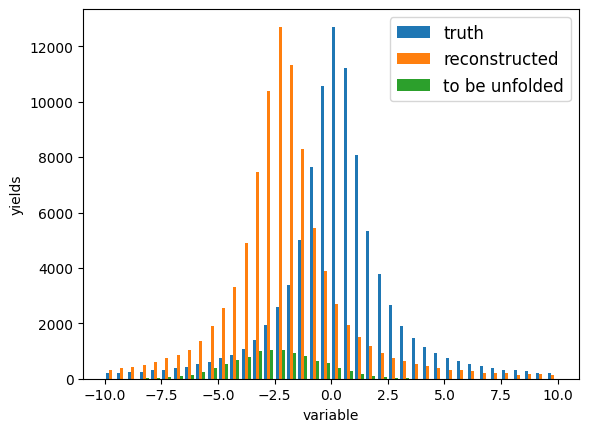

In [3]:
# have a look at the fictional data
my_bins = np.linspace(-10,10,41)

plt.hist([df_train['truth'], df_train['measured'], df_test['measured']], 
         label=['truth', 'reconstructed', 'to be unfolded'], bins = my_bins )
plt.xlabel('variable')
plt.ylabel('yields')
plt.legend(loc='upper right', prop={'size':12})
plt.show()
plt.close()

Let's start with the most simple example. No input bin-wise uncertainty or covariance matrix. The default bin error is square root of the bin count.

In [4]:
# define unfold class with all input

example_a = unfold(
    
    df_train = df_train,                     
    weight_train = df_train['weight'], 
    df_test = df_test,                       
    weight_test = df_test['weight'], 
    name_var_true = 'truth', 
    name_var_reco = 'measured',  
    show_var = 'variable',   # just for plotting
    bins = my_bins,
    mc_stat_err = 0
    
    ## optional input
    # reco_bin_error = measured bin-wiese uncertainty
    # reco_cov = measured covariance matrix
    # kcovtoy = if False, error propagation is based on full covariance matrix; 
    #           if True, error propagation is based on internal toys generated by RooUnfold. Default is False. 
    # mc_stat_err = exclude (0) or include (3, default) or only (2) the effect of MC statistics uncertainty on migration matrix evaluated with interal toys.
    )


Now everything needed to launch unfolding is ready !!!

Let's give it a first try, e.g. SVD method with k=0 (default value will be taken by algorithm, i.e. #bins/2)

In [5]:
#example_a.do_Svd(0)
    
example_a.do_Invert()
#example_a.do_BinByBin()

Subtract -19.4219 fakes from measured distribution
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error


In [6]:
# unfolded result

example_a.result_df

,bin_index,truth_central,truth_stat_error,measured_central,measured_error,unfolded_central,unfolded_error,coverage_perbin
0,0,0.0,0.000000,3.0,1.732051,0.000000e+00,0.000000e+00,0.000000e+00
1,1,0.0,0.000000,5.0,2.236068,1.436464e-13,6.050307e-15,0.000000e+00
2,2,0.0,0.000000,6.0,2.449490,1.323945e-13,8.063323e-15,0.000000e+00
3,3,1.0,1.000000,22.0,4.690416,3.575566e-14,4.570988e-15,0.000000e+00
4,4,0.0,0.000000,34.0,5.830952,3.079031e-01,1.700903e-01,0.000000e+00
5,5,3.0,1.732051,47.0,6.855655,3.240613e+00,1.871750e+00,0.000000e+00
6,6,4.0,2.000000,102.0,10.099505,-2.165148e+00,2.389380e+00,6.780144e-151
7,7,7.0,2.645751,150.0,12.247449,1.498897e+00,2.549966e+00,3.890817e-48
8,8,22.0,4.690416,254.0,15.937377,1.638279e+01,5.063576e+00,5.225316e-30
9,9,33.0,5.744563,404.0,20.099751,2.127180e+01,6.239113e+00,2.684701e-79


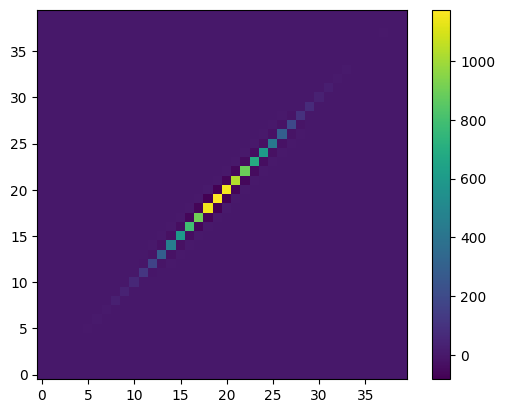

In [7]:
# post-unfold covariance matrix

cov = example_a.result_cov

plt.imshow(cov, origin='lower')
plt.colorbar()
plt.show()

Now we plot the unfolded result comparing with the truth and check the confidence intervals converag, variance and bias for each bin.

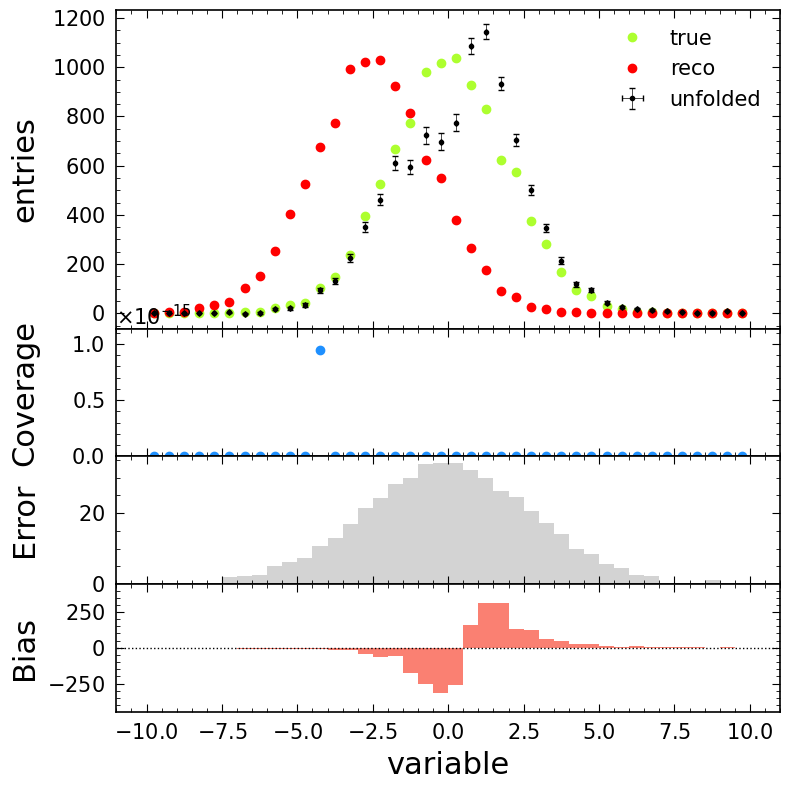

In [8]:
fig = plot_compare_single_run_check(example_a.result_df, my_bins, 'variable', 'entries')

Try other methods..

In [9]:
example_a.do_Svd(30)
unf_cen_svd = example_a.result_df['unfolded_central'].copy()
unf_err_svd = example_a.result_df['unfolded_error'].copy()

example_a.do_Svd(2)
unf_cen_svd_low = example_a.result_df['unfolded_central'].copy()
unf_err_svd_low = example_a.result_df['unfolded_error'].copy()

example_a.do_Invert()
unf_cen_inv = example_a.result_df['unfolded_central'].copy()
unf_err_inv = example_a.result_df['unfolded_error'].copy()

example_a.do_BinByBin()
unf_cen_byb = example_a.result_df['unfolded_central'].copy()
unf_err_byb = example_a.result_df['unfolded_error'].copy()

example_a.do_Bayes(10)
unf_cen_bay = example_a.result_df['unfolded_central'].copy()
unf_err_bay = example_a.result_df['unfolded_error'].copy()

example_a.do_GP()
unf_cen_gp = example_a.result_df['unfolded_central'].copy()
unf_err_gp = example_a.result_df['unfolded_error'].copy()


SVD init 40 x 40 bins, kreg=30
SVD init 40 x 40 bins, kreg=2
Subtract -19.4219 fakes from measured distribution
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Subtract -19.4219 fakes from measured distribution
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 1046
Iteration : 1
Chi^2 of change 0.477427
Iteration : 2
Chi^2 of change 0.0119593
Iteration : 3
Chi^2 of change 0.000592222
Iteration : 4
Chi^2 of change 3.51024e-05
Iteration : 5
Chi^2 of change 2.34568e-06
Iteration : 6
Chi^2 of change 1.70219e-07
Iteration : 7
Chi^2 of change 1.30419e-08
Iteration : 8
Chi^2 of change 1.03461e-09
Iteration : 9
Chi^2 of change 8.38952e-11
Calculating covariances due to number of measured events
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
I

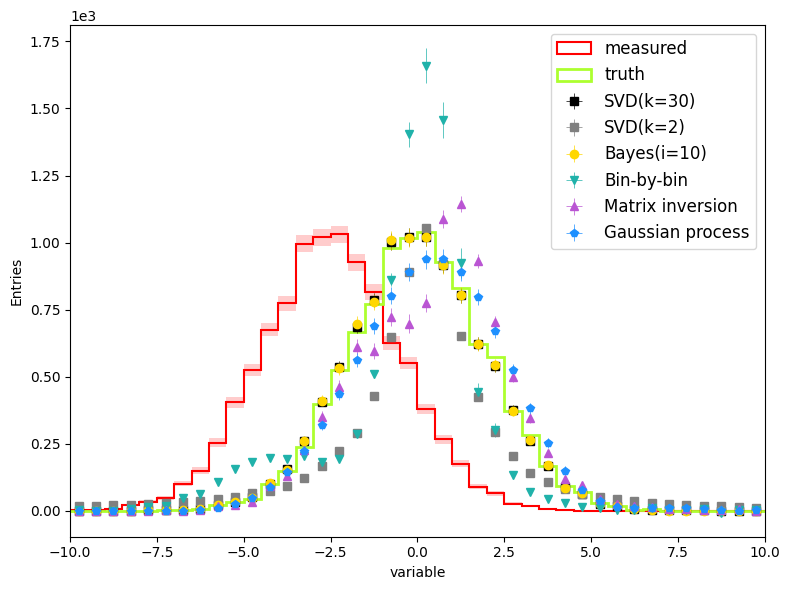

In [10]:
truth_cen = example_a.result_df['truth_central']
measu_cen, measu_err = example_a.result_df['measured_central'], example_a.result_df['measured_error']

f = plt.figure(figsize=(8,6))
plt.hist(get_bin_centers(my_bins), bins=my_bins, weights=measu_cen, histtype='step', lw=1.5, color='red', label='measured')
plt.bar(get_bin_centers(my_bins), height=measu_err*2, width=get_bin_widths(my_bins), bottom=measu_cen - measu_err,
       alpha=0.2, color='red')  

plt.hist(get_bin_centers(my_bins), bins=my_bins, weights=truth_cen, histtype='step', lw=2, color='greenyellow',  label='truth')

plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_svd, yerr=unf_err_svd, xerr=0, marker='s', color='black',ls='', elinewidth=0.5,  label='SVD(k=30)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_svd_low, yerr=unf_err_svd_low, xerr=0, marker='s', color='gray',ls='', elinewidth=0.5, label='SVD(k=2)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_bay, yerr=unf_err_bay, xerr=0, marker='o', color='gold',ls='', elinewidth=0.5,  label='Bayes(i=10)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_byb, yerr=unf_err_byb, xerr=0, marker='v', color='lightseagreen',ls='', elinewidth=0.5,  label='Bin-by-bin')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_inv, yerr=unf_err_inv, xerr=0, marker='^', color='mediumorchid',ls='', elinewidth=0.5,  label='Matrix inversion')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_gp, yerr=unf_err_gp, xerr=0, marker='p', color='dodgerblue',ls='', elinewidth=0.5,  label='Gaussian process')

plt.xlim(-10,10)
plt.xlabel('variable')
plt.ylabel('Entries')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc=1, prop={'size':12})
plt.tight_layout()
plt.show()
plt.close()
f.savefig('compare_all.pdf')


Some FoM are defined for bias study: 

a -- $\sum_{i}{|b_{i}|}$ 

b -- $\sum_{i}{|b_{i}|/N_{i}^{\text{true}}}$

c -- $\sum_{i}{b_{i}}$ 

d -- $\sqrt{\sum_{i,j}Cov_{i,j}}$

e -- $\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$ 

f -- $\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$ 

g -- $\sum_{i}{|b_{i}|}/\sqrt{Cov_{i,i}}$ 

h -- confidence interval coverage probability $\Phi(\frac{b_i}{\sigma_i} +1) - \Phi(\frac{b_i}{\sigma_i} -1)$

where $b_{i} = N_{i}^{\text{unfolded}} - N_{i}^{\text{true}}$ is the bias in each bin, and $Cov_{i,j}$ is the obtained post-unfold covariance matrix. $\Phi$ is the normal cumulative distribution function.

In [11]:
# calculate all FOM
example_a.do_Svd(28)
example_a.check_bias()

SVD init 40 x 40 bins, kreg=28


In [12]:
example_a.bias_h

0.5783116794601137

Use toys to compare the FOM obtained with different unfolding method or parameters. 

Toys can be generated from the input measured covariance matrix or bin error. If none of them are provided, a Poisson distrition based on the statistical error of bin count will be used.

In [13]:
# define toy class

example_toy = toy_unfold(
    
    df_train = df_train,                     
    weight_train = df_train['weight'], 
    df_test = df_test,                       
    weight_test = df_test['weight'], 
    name_var_true = 'truth', 
    name_var_reco = 'measured',  
    show_var = 'variable',   # just for plotting
    bins = my_bins,
    toy_size = 10  # number of toys
)
    
    ## optional input
    # reco_bin_error = measured bin-wiese uncertainty
    # reco_cov = measured covariance matrix
    # kcovtoy = if False, error propagation is based on full covariance matrix; 
    #           if True, error propagation is based on internal toys generated by RooUnfold. Default is False. 
    # mc_stat_err = exclude (0, default) or include (1) or only (2) the effect of MC statistics uncertainty on migration matrix evaluated with interal toys.

Then, we can use different unfolding mothod for the toys. 

In [14]:
# try matirx inversion method
example_toy.do_toyUnfold(method='Invert',
                         get_fom=True  # include the FOM calculation result
                        ) 
inv_cen = example_toy.result_cen_mean
inv_err = example_toy.result_cen_err
inv_fom = example_toy.dict_fom

Subtract -19.2529 fakes from measured distribution
Subtract -19.1208 fakes from measured distribution
Subtract -19.3403 fakes from measured distribution
Subtract -19.2976 fakes from measured distribution
Subtract -19.5986 fakes from measured distribution
Subtract -19.4743 fakes from measured distribution
Subtract -19.5559 fakes from measured distribution
Subtract -19.4219 fakes from measured distribution
Subtract -19.4335 fakes from measured distribution
Subtract -19.0625 fakes from measured distribution


/afs/desy.de/user/l/lcaocn/.local/lib/python3.11/site-packages/pyroounfold/utils/bias_study.py:57: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


In [15]:
# try SVD method with scanning various k parameter

k_arr = np.arange(2, example_toy.nbins+1).tolist()

svd_cen, svd_err, svd_coverage, svd_fom = example_toy.do_toyUnfold_scan(method='Svd', para_arr=k_arr, get_fom=True)

Loop in given parameters......
para = 2
para = 3
para = 4
para = 5
para = 6
para = 7
para = 8
para = 9
para = 10
para = 11
para = 12
para = 13
para = 14
para = 15
para = 16
para = 17
para = 18
para = 19
para = 20
para = 21
para = 22
para = 23
para = 24
para = 25
para = 26
para = 27
para = 28
para = 29
para = 30
para = 31
para = 32
para = 33
para = 34
para = 35
para = 36
para = 37
para = 38
para = 39
para = 40
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=2
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 bins, kreg=3
SVD init 40 x 40 

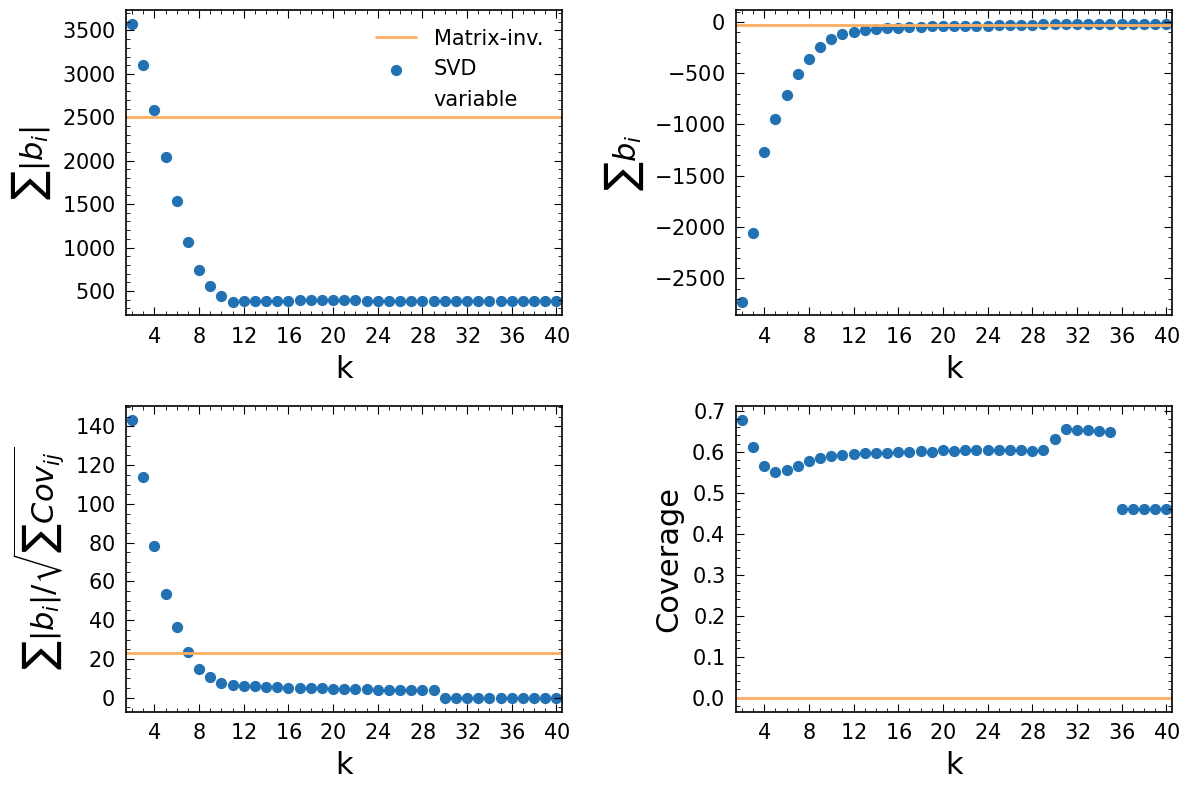

In [16]:
# compare the result
# User can define own plotting function
# Some examples can be found in ./plotting.py

plot_unf_fom_my(k_arr, svd_fom, inv_fom, example_toy.show_var, leg=1) 

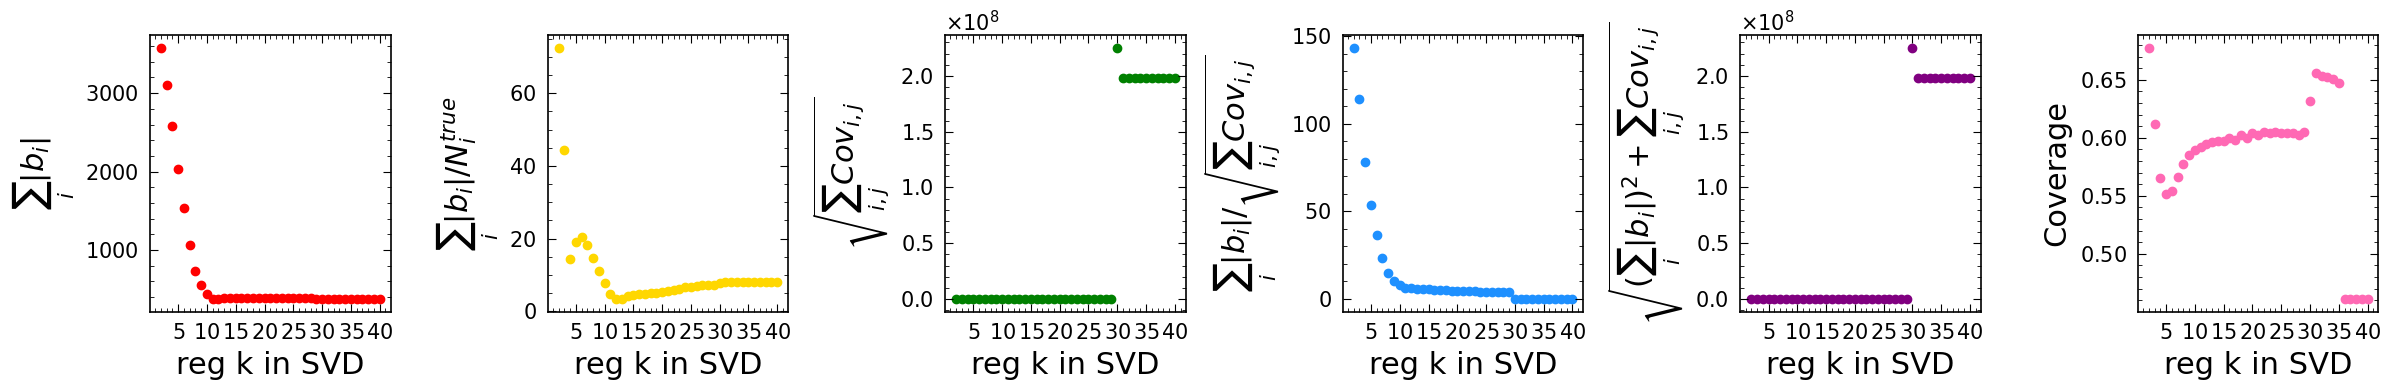

In [17]:
foms    = [svd_fom['fom_a'], svd_fom['fom_b'], svd_fom['fom_d'], svd_fom['fom_e'], svd_fom['fom_f'],svd_fom['fom_h']]

colors    = ['red', 'gold', 'green', 'dodgerblue', 'purple', 'hotpink']

fom_names = ['$\sum_{i}{|b_{i}|}$', 
             '$\sum_{i}{|b_{i}|/N_{i}^{true}}$',
             '$\sqrt{\sum_{i,j}Cov_{i,j}}$',
             '$\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$', 
             '$\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$', 'Coverage' ]

last_k = 40

# plot until last_k
fig_svd_para = plot_compare_para(len(foms), k_arr, 'reg k in SVD', foms, fom_names, colors, 'variable', last_k)
fig_svd_para.savefig('svd_fom.pdf')

In the reality, it would be better to have a look at the response matrix (migration matrix) before actual unfolding, e.g. to get some feeling to improve the binning, where the guidelines include avoiding low stat. bin and bin_width << resolution.

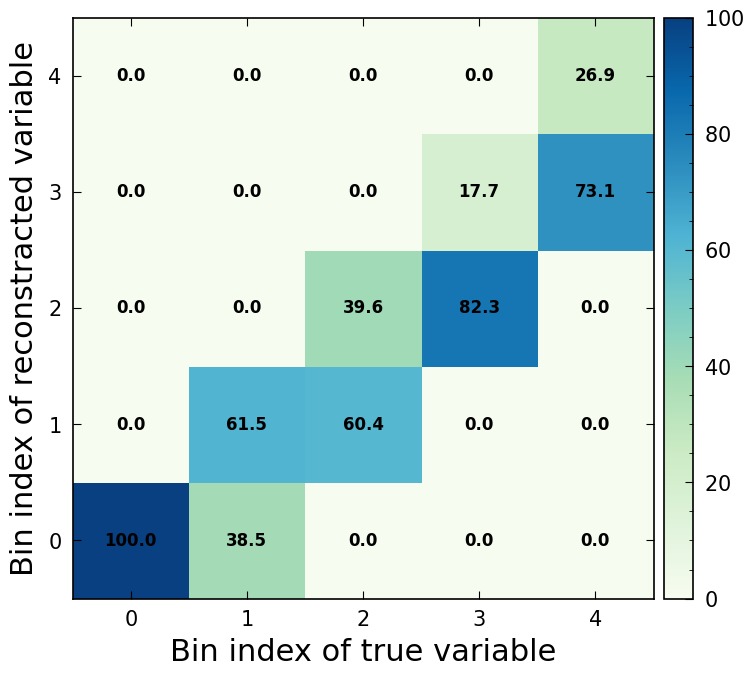

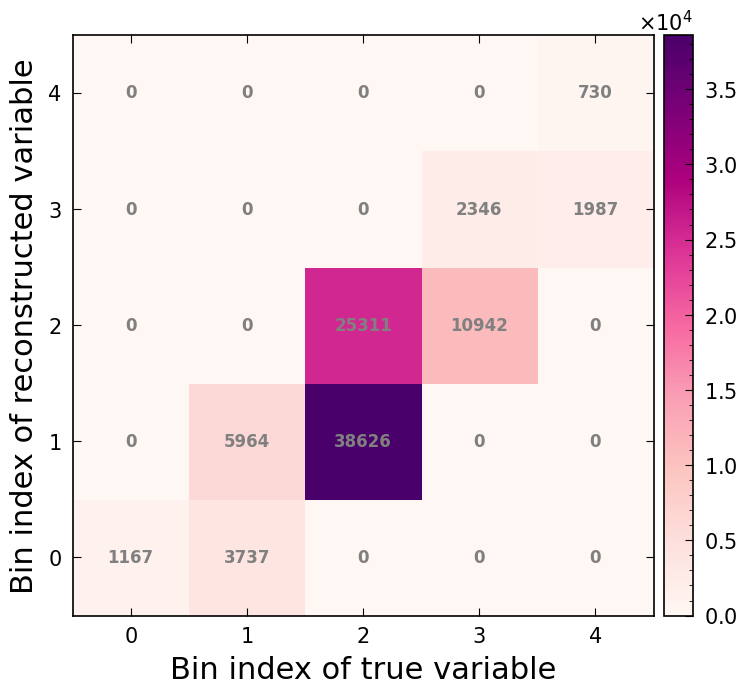

In [18]:
# plot migration matrix and entries matrix

mig_matrix, hist, mig_fig, n_fig = get_migration(
    true_data =df_train['truth'], 
    reco_data =df_train['measured'], 
    weight    =df_train['weight'], 
    bin_var   =np.linspace(-10,10,6), 
    name_var  ='variable')